# Best model cross-validation

In other notebooks we have trained traditional machine learning models and deep learning models. We mainly assessed the performance by looking at the scores on the test set. This approach is fine for finding the best performing model. However, by using such an approach, we do not have unbiased age predictions for all subjects. This information can be useful for research. 

Using a model we have trained on the training set to make predictions on the training set will result in a lot of bias in the predictions. Therefore, we use 7-fold cross-validation and retrain the model to get predictions for the training set with less bias. Please note that there still is bias in the cross-validated model, as the hyperparameter selection has been performed on this training set.

In this notebook, we will re-train the best (deep learning) model and use 7-fold cross-validation to make predictions on the full data set. By doing this, we will have performance on the data set as a whole, and we will have unbiased predictions for the whole data set.

In [11]:
import sys, os, fnmatch, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.dirname(os.getcwd()))

from config import PATH_DATA_PROCESSED_DL, PATH_MODELS, PATH_METADATA

## Load preprocessed data

In [2]:
%%time

# Load all the metadata

from sklearn.model_selection import train_test_split

# Step 1: Get all the files in the output folder
file_names = os.listdir(PATH_DATA_PROCESSED_DL)

# Step 2: Get the full paths of the files (without extensions)
files = [os.path.splitext(os.path.join(PATH_DATA_PROCESSED_DL, file_name))[0] for file_name in fnmatch.filter(file_names, "*.zarr")]

# Step 3: Load all the metadata
frames = []

for idx, feature_file in enumerate(files):
    df_metadata = pd.read_csv(feature_file.replace("processed_raw_", "processed_metadata_") + ".csv")
    frames.append(df_metadata)

df_metadata = pd.concat(frames) 

# Step 4: Add missing age information based on the age group the subject is in
df_metadata['age_months'].fillna(df_metadata['age_group'], inplace=True)
df_metadata['age_days'].fillna(df_metadata['age_group']*30, inplace=True)
df_metadata['age_years'].fillna(df_metadata['age_group']/12, inplace=True)

# Step 5: List all the unique subject IDs
subject_ids = sorted(list(set(df_metadata["code"].tolist())))

CPU times: user 7.12 s, sys: 2.47 s, total: 9.59 s
Wall time: 12.8 s


In [3]:
import random

# Function to divide the subjects into equal sized chunks
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out


random.seed(42)
random.shuffle(subject_ids)

IDs_folds = chunkIt(subject_ids, 7)

In [4]:
IDs_folds

[[707,
  152,
  474,
  24,
  716,
  307,
  107,
  40,
  454,
  473,
  407,
  411,
  603,
  324,
  624,
  750,
  453,
  738,
  742,
  6,
  729,
  328,
  620,
  737,
  708,
  2,
  123,
  641,
  420,
  105,
  325,
  739,
  488,
  613,
  134,
  21,
  14,
  633,
  728,
  625,
  102,
  153,
  612],
 [306,
  723,
  314,
  713,
  304,
  630,
  466,
  301,
  756,
  171,
  734,
  121,
  337,
  33,
  702,
  719,
  308,
  438,
  168,
  7,
  30,
  726,
  422,
  338,
  317,
  724,
  629,
  329,
  456,
  38,
  145,
  740,
  114,
  342,
  632,
  182,
  8,
  486,
  10,
  428,
  487,
  426,
  449],
 [754,
  623,
  430,
  621,
  326,
  340,
  39,
  747,
  758,
  146,
  457,
  725,
  608,
  167,
  128,
  703,
  173,
  646,
  170,
  348,
  179,
  701,
  409,
  485,
  157,
  714,
  101,
  27,
  150,
  139,
  166,
  616,
  443,
  441,
  427,
  637,
  601,
  305,
  618,
  636,
  11,
  704,
  627,
  604],
 [140,
  158,
  459,
  425,
  5,
  755,
  164,
  414,
  481,
  346,
  617,
  178,
  626,
  126,
  410,
  1

In [5]:
df_metadata

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,23,/Volumes/Seagate Expansion Drive/ePodium/Data/...,023_35_mc_mmn36,35,1052.0,35.066667,2.922222
0,337,/Volumes/Seagate Expansion Drive/ePodium/Data/...,337_23_jc_mmn_36_wk,23,692.0,23.066667,1.922222
0,456,/Volumes/Seagate Expansion Drive/ePodium/Data/...,456_23_md_mmn36_wk,23,691.0,23.033333,1.919444
0,328,/Volumes/Seagate Expansion Drive/ePodium/Data/...,328_23_jc_mmn36_wk,23,699.0,23.300000,1.941667
0,314,/Volumes/Seagate Expansion Drive/ePodium/Data/...,314_29_mmn_36_wk,29,877.0,29.233333,2.436111
...,...,...,...,...,...,...,...
0,348,/Volumes/Seagate Expansion Drive/ePodium/Data/...,348_29_jc_mmn25_wk,29,858.0,28.600000,2.383333
0,9,/Volumes/Seagate Expansion Drive/ePodium/Data/...,009_23_jc_mmn58,23,692.0,23.066667,1.922222
0,751,/Volumes/Seagate Expansion Drive/ePodium/Data/...,751-452-29m-jr-mmn36,29,869.0,28.966667,2.413889
0,348,/Volumes/Seagate Expansion Drive/ePodium/Data/...,348_17_jc_mmn25_wk,17,512.0,17.066667,1.422222


## Train 7 Encoder models

In [6]:
from dataset_generator import DataGenerator

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, BatchNormalization, Dense, Conv1D, LeakyReLU, AveragePooling1D, Flatten, Reshape, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import time

n_timesteps = 501
n_features = 30 
n_outputs = 1

input_shape = (n_timesteps, n_features)

In [8]:
import tensorflow_addons as tfa

def encoder_model():
    """ Returns the Encoder model from Ismail Fawaz et al. (2019). """
    input_layer = keras.layers.Input(input_shape)

    # conv block -1
    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(input_layer)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    output_layer = keras.layers.Dense(1)(flatten_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    return model

/Users/bbruns/anaconda3/envs/mne/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [9]:
def flatten(t):
    return [item for sublist in t for item in sublist]

for i in range(7):
    # Create new generators
    IDs_temp = IDs_folds.copy()
    
    del(IDs_temp[i]) # Remove current fold
    del(IDs_temp[i % 6]) # Remove validation fold
    
    IDs_temp = flatten(IDs_temp) # Flatten remaining folds
    
    train_generator_noise = DataGenerator(list_IDs = IDs_temp,
                                      BASE_PATH = PATH_DATA_PROCESSED_DL,
                                      metadata = df_metadata,
                                      n_average = 30,
                                      batch_size = 10,
                                      gaussian_noise=0.01,
                                      iter_per_epoch = 30,
                                      n_timepoints = 501, 
                                      n_channels=30, 
                                      shuffle=True)

    
    val_generator = DataGenerator(list_IDs = IDs_folds[(i+1) % 7],
                              BASE_PATH = PATH_DATA_PROCESSED_DL,
                              metadata = df_metadata,
                              n_average = 30,
                              batch_size = 10,
                              iter_per_epoch = 100,
                              n_timepoints = 501,
                              n_channels=30,
                              shuffle=True)
    
    epochs = 1000
    
    output_filename = f'Encoder_regressor_CROSSVALIDATION_NEW_{i}'
    output_file = os.path.join(PATH_MODELS, output_filename)
    
    checkpointer = ModelCheckpoint(filepath = output_file + ".hdf5", monitor='val_loss', verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(monitor='val_loss', patience=300, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=0.00001, verbose=1)
    
    optimizer = Adam(learning_rate=0.01)

    model = encoder_model()
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    history = model.fit(x=train_generator_noise,
                        validation_data=val_generator,
                        epochs=epochs, 
                        callbacks=[checkpointer, earlystopper, reduce_lr])

Epoch 1/1000
143/143 [==============================] - 151s 1s/step - loss: 190.1889 - root_mean_squared_error: 13.4198 - mean_absolute_error: 10.9516 - val_loss: 113.6864 - val_root_mean_squared_error: 10.6624 - val_mean_absolute_error: 8.9615

Epoch 00001: val_loss improved from inf to 113.68642, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_CROSSVALIDATION_4.hdf5
Epoch 2/1000
143/143 [==============================] - 139s 971ms/step - loss: 97.7661 - root_mean_squared_error: 9.8848 - mean_absolute_error: 8.0439 - val_loss: 102.1132 - val_root_mean_squared_error: 10.1051 - val_mean_absolute_error: 8.3816

Epoch 00002: val_loss improved from 113.68642 to 102.11320, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_CROSSVALIDATION_4.hdf5
Epoch 3/1000
143/143 [==============================] - 118s 824ms/step - loss: 97.2049 - root_mean_squared_error: 9.8560 - mean


Epoch 00050: val_loss did not improve from 64.55397
Epoch 51/1000
143/143 [==============================] - 147s 1s/step - loss: 65.4509 - root_mean_squared_error: 8.0885 - mean_absolute_error: 6.5990 - val_loss: 59.2973 - val_root_mean_squared_error: 7.7005 - val_mean_absolute_error: 6.2217

Epoch 00051: val_loss improved from 64.55397 to 59.29731, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_CROSSVALIDATION_4.hdf5
Epoch 52/1000
143/143 [==============================] - 181s 1s/step - loss: 63.2187 - root_mean_squared_error: 7.9482 - mean_absolute_error: 6.4474 - val_loss: 85.7678 - val_root_mean_squared_error: 9.2611 - val_mean_absolute_error: 7.5555

Epoch 00052: val_loss did not improve from 59.29731
Epoch 53/1000
143/143 [==============================] - 134s 936ms/step - loss: 67.7731 - root_mean_squared_error: 8.2289 - mean_absolute_error: 6.7748 - val_loss: 71.2503 - val_root_mean_squared_error: 8.4410 - val_me

143/143 [==============================] - 105s 735ms/step - loss: 58.7921 - root_mean_squared_error: 7.6664 - mean_absolute_error: 6.1507 - val_loss: 67.8532 - val_root_mean_squared_error: 8.2373 - val_mean_absolute_error: 6.6469

Epoch 00077: val_loss did not improve from 50.92939
Epoch 78/1000
143/143 [==============================] - 105s 737ms/step - loss: 64.1829 - root_mean_squared_error: 8.0055 - mean_absolute_error: 6.4574 - val_loss: 59.2525 - val_root_mean_squared_error: 7.6976 - val_mean_absolute_error: 6.3320

Epoch 00078: val_loss did not improve from 50.92939
Epoch 79/1000
143/143 [==============================] - 107s 748ms/step - loss: 59.7215 - root_mean_squared_error: 7.7245 - mean_absolute_error: 6.1927 - val_loss: 65.7730 - val_root_mean_squared_error: 8.1101 - val_mean_absolute_error: 6.6482

Epoch 00079: val_loss did not improve from 50.92939
Epoch 80/1000
143/143 [==============================] - 120s 841ms/step - loss: 52.2109 - root_mean_squared_error: 7.21


Epoch 00104: val_loss did not improve from 50.92939
Epoch 105/1000
143/143 [==============================] - 164s 1s/step - loss: 50.4902 - root_mean_squared_error: 7.1030 - mean_absolute_error: 5.7041 - val_loss: 68.5913 - val_root_mean_squared_error: 8.2820 - val_mean_absolute_error: 6.7765

Epoch 00105: val_loss did not improve from 50.92939
Epoch 106/1000
143/143 [==============================] - 245s 2s/step - loss: 44.3163 - root_mean_squared_error: 6.6556 - mean_absolute_error: 5.3808 - val_loss: 67.0938 - val_root_mean_squared_error: 8.1911 - val_mean_absolute_error: 6.5396

Epoch 00106: val_loss did not improve from 50.92939
Epoch 107/1000
143/143 [==============================] - 315s 2s/step - loss: 49.0288 - root_mean_squared_error: 7.0013 - mean_absolute_error: 5.5363 - val_loss: 62.6232 - val_root_mean_squared_error: 7.9135 - val_mean_absolute_error: 6.5123

Epoch 00107: val_loss did not improve from 50.92939
Epoch 108/1000
143/143 [==============================] - 2


Epoch 00159: val_loss did not improve from 50.92939
Epoch 160/1000
143/143 [==============================] - 146s 1s/step - loss: 42.2476 - root_mean_squared_error: 6.4976 - mean_absolute_error: 5.1066 - val_loss: 70.0267 - val_root_mean_squared_error: 8.3682 - val_mean_absolute_error: 6.7135

Epoch 00160: val_loss did not improve from 50.92939
Epoch 161/1000
143/143 [==============================] - 137s 956ms/step - loss: 44.0108 - root_mean_squared_error: 6.6289 - mean_absolute_error: 5.2077 - val_loss: 59.8123 - val_root_mean_squared_error: 7.7338 - val_mean_absolute_error: 6.1459

Epoch 00161: val_loss did not improve from 50.92939
Epoch 162/1000
143/143 [==============================] - 139s 970ms/step - loss: 41.0171 - root_mean_squared_error: 6.3980 - mean_absolute_error: 5.1454 - val_loss: 76.5238 - val_root_mean_squared_error: 8.7478 - val_mean_absolute_error: 7.1719

Epoch 00162: val_loss did not improve from 50.92939
Epoch 163/1000
143/143 [=============================

143/143 [==============================] - 128s 900ms/step - loss: 43.1534 - root_mean_squared_error: 6.5648 - mean_absolute_error: 5.2192 - val_loss: 55.2755 - val_root_mean_squared_error: 7.4348 - val_mean_absolute_error: 6.0193

Epoch 00187: val_loss did not improve from 48.76865
Epoch 188/1000
143/143 [==============================] - 123s 860ms/step - loss: 40.5640 - root_mean_squared_error: 6.3671 - mean_absolute_error: 5.0877 - val_loss: 65.8647 - val_root_mean_squared_error: 8.1157 - val_mean_absolute_error: 6.6462

Epoch 00188: val_loss did not improve from 48.76865
Epoch 189/1000
143/143 [==============================] - 121s 847ms/step - loss: 37.7579 - root_mean_squared_error: 6.1370 - mean_absolute_error: 4.8228 - val_loss: 66.5460 - val_root_mean_squared_error: 8.1576 - val_mean_absolute_error: 6.8496

Epoch 00189: val_loss did not improve from 48.76865
Epoch 190/1000
143/143 [==============================] - 104s 726ms/step - loss: 42.1743 - root_mean_squared_error: 6

143/143 [==============================] - 104s 730ms/step - loss: 35.1272 - root_mean_squared_error: 5.9235 - mean_absolute_error: 4.7147 - val_loss: 72.8568 - val_root_mean_squared_error: 8.5356 - val_mean_absolute_error: 7.0464

Epoch 00241: val_loss did not improve from 48.76865
Epoch 242/1000
143/143 [==============================] - 103s 723ms/step - loss: 38.4963 - root_mean_squared_error: 6.1958 - mean_absolute_error: 4.9157 - val_loss: 62.5282 - val_root_mean_squared_error: 7.9075 - val_mean_absolute_error: 6.4161

Epoch 00242: val_loss did not improve from 48.76865
Epoch 243/1000
143/143 [==============================] - 101s 709ms/step - loss: 33.7029 - root_mean_squared_error: 5.8040 - mean_absolute_error: 4.5899 - val_loss: 69.6835 - val_root_mean_squared_error: 8.3477 - val_mean_absolute_error: 6.8709

Epoch 00243: val_loss did not improve from 48.76865
Epoch 244/1000
143/143 [==============================] - 106s 741ms/step - loss: 33.0472 - root_mean_squared_error: 5


Epoch 00294: val_loss did not improve from 47.18885
Epoch 295/1000
143/143 [==============================] - 105s 734ms/step - loss: 32.9388 - root_mean_squared_error: 5.7351 - mean_absolute_error: 4.5478 - val_loss: 67.4588 - val_root_mean_squared_error: 8.2133 - val_mean_absolute_error: 6.6556

Epoch 00295: val_loss did not improve from 47.18885
Epoch 296/1000
143/143 [==============================] - 103s 723ms/step - loss: 34.7033 - root_mean_squared_error: 5.8889 - mean_absolute_error: 4.6953 - val_loss: 58.6896 - val_root_mean_squared_error: 7.6609 - val_mean_absolute_error: 6.1728

Epoch 00296: val_loss did not improve from 47.18885
Epoch 297/1000
143/143 [==============================] - 103s 717ms/step - loss: 34.9332 - root_mean_squared_error: 5.9085 - mean_absolute_error: 4.5925 - val_loss: 71.3235 - val_root_mean_squared_error: 8.4453 - val_mean_absolute_error: 6.7216

Epoch 00297: val_loss did not improve from 47.18885
Epoch 298/1000
143/143 [==========================

143/143 [==============================] - 112s 781ms/step - loss: 30.5941 - root_mean_squared_error: 5.5280 - mean_absolute_error: 4.4208 - val_loss: 73.0060 - val_root_mean_squared_error: 8.5444 - val_mean_absolute_error: 6.9988

Epoch 00349: val_loss did not improve from 47.18885
Epoch 350/1000
143/143 [==============================] - 108s 754ms/step - loss: 32.2456 - root_mean_squared_error: 5.6749 - mean_absolute_error: 4.4397 - val_loss: 65.1776 - val_root_mean_squared_error: 8.0733 - val_mean_absolute_error: 6.4975

Epoch 00350: val_loss did not improve from 47.18885
Epoch 351/1000
143/143 [==============================] - 110s 771ms/step - loss: 31.5619 - root_mean_squared_error: 5.6171 - mean_absolute_error: 4.4671 - val_loss: 74.5275 - val_root_mean_squared_error: 8.6329 - val_mean_absolute_error: 7.1043

Epoch 00351: val_loss did not improve from 47.18885
Epoch 352/1000
143/143 [==============================] - 108s 755ms/step - loss: 32.0696 - root_mean_squared_error: 5

143/143 [==============================] - 100s 702ms/step - loss: 31.2728 - root_mean_squared_error: 5.5875 - mean_absolute_error: 4.3571 - val_loss: 70.0215 - val_root_mean_squared_error: 8.3679 - val_mean_absolute_error: 6.8270

Epoch 00403: val_loss did not improve from 47.18885
Epoch 404/1000
143/143 [==============================] - 101s 709ms/step - loss: 32.8049 - root_mean_squared_error: 5.7223 - mean_absolute_error: 4.3814 - val_loss: 81.4598 - val_root_mean_squared_error: 9.0255 - val_mean_absolute_error: 7.4930

Epoch 00404: val_loss did not improve from 47.18885
Epoch 405/1000
143/143 [==============================] - 100s 700ms/step - loss: 32.4827 - root_mean_squared_error: 5.6866 - mean_absolute_error: 4.4076 - val_loss: 72.5123 - val_root_mean_squared_error: 8.5154 - val_mean_absolute_error: 6.7086

Epoch 00405: val_loss did not improve from 47.18885
Epoch 406/1000
143/143 [==============================] - 99s 695ms/step - loss: 33.8484 - root_mean_squared_error: 5.

143/143 [==============================] - 100s 699ms/step - loss: 31.4020 - root_mean_squared_error: 5.6029 - mean_absolute_error: 4.3476 - val_loss: 82.4699 - val_root_mean_squared_error: 9.0813 - val_mean_absolute_error: 7.4296

Epoch 00457: val_loss did not improve from 47.18885
Epoch 458/1000
143/143 [==============================] - 101s 710ms/step - loss: 34.3523 - root_mean_squared_error: 5.8580 - mean_absolute_error: 4.5267 - val_loss: 64.9785 - val_root_mean_squared_error: 8.0609 - val_mean_absolute_error: 6.5682

Epoch 00458: val_loss did not improve from 47.18885
Epoch 459/1000
143/143 [==============================] - 100s 697ms/step - loss: 34.5227 - root_mean_squared_error: 5.8707 - mean_absolute_error: 4.6174 - val_loss: 91.0937 - val_root_mean_squared_error: 9.5443 - val_mean_absolute_error: 7.7581

Epoch 00459: val_loss did not improve from 47.18885
Epoch 460/1000
143/143 [==============================] - 101s 705ms/step - loss: 30.9531 - root_mean_squared_error: 5


Epoch 00484: val_loss did not improve from 47.18885
Epoch 485/1000
143/143 [==============================] - 100s 699ms/step - loss: 30.4661 - root_mean_squared_error: 5.5175 - mean_absolute_error: 4.3219 - val_loss: 66.9988 - val_root_mean_squared_error: 8.1853 - val_mean_absolute_error: 6.8121

Epoch 00485: val_loss did not improve from 47.18885
Epoch 486/1000
143/143 [==============================] - 99s 694ms/step - loss: 36.7271 - root_mean_squared_error: 6.0553 - mean_absolute_error: 4.6799 - val_loss: 71.0520 - val_root_mean_squared_error: 8.4292 - val_mean_absolute_error: 6.9824

Epoch 00486: val_loss did not improve from 47.18885

Epoch 00486: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
Epoch 487/1000
143/143 [==============================] - 99s 690ms/step - loss: 31.4201 - root_mean_squared_error: 5.5876 - mean_absolute_error: 4.3816 - val_loss: 78.9712 - val_root_mean_squared_error: 8.8866 - val_mean_absolute_error: 7.2491

Epoch 00487: val_loss d

143/143 [==============================] - 99s 694ms/step - loss: 30.0617 - root_mean_squared_error: 5.4766 - mean_absolute_error: 4.3292 - val_loss: 78.6431 - val_root_mean_squared_error: 8.8681 - val_mean_absolute_error: 7.0359

Epoch 00512: val_loss did not improve from 47.18885
Epoch 513/1000
143/143 [==============================] - 101s 709ms/step - loss: 33.2675 - root_mean_squared_error: 5.7618 - mean_absolute_error: 4.4924 - val_loss: 76.8655 - val_root_mean_squared_error: 8.7673 - val_mean_absolute_error: 7.2215

Epoch 00513: val_loss did not improve from 47.18885
Epoch 514/1000
143/143 [==============================] - 100s 699ms/step - loss: 32.4514 - root_mean_squared_error: 5.6933 - mean_absolute_error: 4.4435 - val_loss: 75.9095 - val_root_mean_squared_error: 8.7126 - val_mean_absolute_error: 7.0799

Epoch 00514: val_loss did not improve from 47.18885
Epoch 515/1000
143/143 [==============================] - 100s 698ms/step - loss: 30.3627 - root_mean_squared_error: 5.


Epoch 00566: val_loss did not improve from 47.18885
Epoch 567/1000
143/143 [==============================] - 98s 686ms/step - loss: 29.8039 - root_mean_squared_error: 5.4553 - mean_absolute_error: 4.2845 - val_loss: 72.5964 - val_root_mean_squared_error: 8.5204 - val_mean_absolute_error: 6.9582

Epoch 00567: val_loss did not improve from 47.18885
Epoch 568/1000
143/143 [==============================] - 99s 694ms/step - loss: 32.3512 - root_mean_squared_error: 5.6841 - mean_absolute_error: 4.4201 - val_loss: 65.7597 - val_root_mean_squared_error: 8.1092 - val_mean_absolute_error: 6.5991

Epoch 00568: val_loss did not improve from 47.18885
Epoch 569/1000
143/143 [==============================] - 99s 691ms/step - loss: 36.4369 - root_mean_squared_error: 6.0322 - mean_absolute_error: 4.7581 - val_loss: 71.0190 - val_root_mean_squared_error: 8.4273 - val_mean_absolute_error: 6.8345

Epoch 00569: val_loss did not improve from 47.18885
Epoch 570/1000
143/143 [=============================


Epoch 00006: val_loss did not improve from 77.97405
Epoch 7/1000
148/148 [==============================] - 98s 665ms/step - loss: 81.2942 - root_mean_squared_error: 9.0113 - mean_absolute_error: 7.3876 - val_loss: 93.4026 - val_root_mean_squared_error: 9.6645 - val_mean_absolute_error: 7.7860

Epoch 00007: val_loss did not improve from 77.97405
Epoch 8/1000
148/148 [==============================] - 100s 673ms/step - loss: 81.3437 - root_mean_squared_error: 9.0131 - mean_absolute_error: 7.3539 - val_loss: 83.5482 - val_root_mean_squared_error: 9.1405 - val_mean_absolute_error: 7.5564

Epoch 00008: val_loss did not improve from 77.97405
Epoch 9/1000
148/148 [==============================] - 98s 664ms/step - loss: 78.2807 - root_mean_squared_error: 8.8433 - mean_absolute_error: 7.1270 - val_loss: 96.9658 - val_root_mean_squared_error: 9.8471 - val_mean_absolute_error: 7.8115

Epoch 00009: val_loss did not improve from 77.97405
Epoch 10/1000
148/148 [==============================] - 9

148/148 [==============================] - 101s 684ms/step - loss: 66.3952 - root_mean_squared_error: 8.1426 - mean_absolute_error: 6.4909 - val_loss: 80.3124 - val_root_mean_squared_error: 8.9617 - val_mean_absolute_error: 7.4820

Epoch 00034: val_loss did not improve from 68.33849
Epoch 35/1000
148/148 [==============================] - 96s 649ms/step - loss: 77.1009 - root_mean_squared_error: 8.7755 - mean_absolute_error: 7.1549 - val_loss: 80.2864 - val_root_mean_squared_error: 8.9603 - val_mean_absolute_error: 7.5032

Epoch 00035: val_loss did not improve from 68.33849
Epoch 36/1000
148/148 [==============================] - 100s 676ms/step - loss: 68.0905 - root_mean_squared_error: 8.2442 - mean_absolute_error: 6.7033 - val_loss: 64.3337 - val_root_mean_squared_error: 8.0208 - val_mean_absolute_error: 6.4651

Epoch 00036: val_loss improved from 68.33849 to 64.33366, saving model to /Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/Encoder_regressor_CROSSV


Epoch 00059: val_loss did not improve from 54.92082
Epoch 60/1000
148/148 [==============================] - 96s 651ms/step - loss: 64.7601 - root_mean_squared_error: 8.0382 - mean_absolute_error: 6.5547 - val_loss: 67.0754 - val_root_mean_squared_error: 8.1900 - val_mean_absolute_error: 6.5316

Epoch 00060: val_loss did not improve from 54.92082
Epoch 61/1000
148/148 [==============================] - 95s 640ms/step - loss: 60.5086 - root_mean_squared_error: 7.7750 - mean_absolute_error: 6.2150 - val_loss: 70.1334 - val_root_mean_squared_error: 8.3746 - val_mean_absolute_error: 6.7049

Epoch 00061: val_loss did not improve from 54.92082
Epoch 62/1000
148/148 [==============================] - 96s 646ms/step - loss: 57.6910 - root_mean_squared_error: 7.5910 - mean_absolute_error: 6.0683 - val_loss: 59.2403 - val_root_mean_squared_error: 7.6968 - val_mean_absolute_error: 6.2666

Epoch 00062: val_loss did not improve from 54.92082
Epoch 63/1000
148/148 [==============================] -

148/148 [==============================] - 102s 688ms/step - loss: 51.6822 - root_mean_squared_error: 7.1874 - mean_absolute_error: 5.7271 - val_loss: 62.4949 - val_root_mean_squared_error: 7.9054 - val_mean_absolute_error: 6.4204

Epoch 00086: val_loss did not improve from 48.47983
Epoch 87/1000
148/148 [==============================] - 101s 685ms/step - loss: 51.1812 - root_mean_squared_error: 7.1510 - mean_absolute_error: 5.6757 - val_loss: 104.7098 - val_root_mean_squared_error: 10.2328 - val_mean_absolute_error: 8.1506

Epoch 00087: val_loss did not improve from 48.47983
Epoch 88/1000
148/148 [==============================] - 101s 686ms/step - loss: 60.4874 - root_mean_squared_error: 7.7690 - mean_absolute_error: 6.2731 - val_loss: 55.5207 - val_root_mean_squared_error: 7.4512 - val_mean_absolute_error: 5.9332

Epoch 00088: val_loss did not improve from 48.47983
Epoch 89/1000
148/148 [==============================] - 102s 689ms/step - loss: 52.9625 - root_mean_squared_error: 7.

148/148 [==============================] - 101s 681ms/step - loss: 48.2165 - root_mean_squared_error: 6.9407 - mean_absolute_error: 5.5537 - val_loss: 57.7679 - val_root_mean_squared_error: 7.6005 - val_mean_absolute_error: 6.1751

Epoch 00113: val_loss did not improve from 43.67553
Epoch 114/1000
148/148 [==============================] - 101s 684ms/step - loss: 49.0208 - root_mean_squared_error: 6.9983 - mean_absolute_error: 5.5905 - val_loss: 61.9347 - val_root_mean_squared_error: 7.8699 - val_mean_absolute_error: 6.4956

Epoch 00114: val_loss did not improve from 43.67553
Epoch 115/1000
148/148 [==============================] - 102s 690ms/step - loss: 52.3116 - root_mean_squared_error: 7.2263 - mean_absolute_error: 5.7627 - val_loss: 46.2251 - val_root_mean_squared_error: 6.7989 - val_mean_absolute_error: 5.7122

Epoch 00115: val_loss did not improve from 43.67553
Epoch 116/1000
148/148 [==============================] - 102s 691ms/step - loss: 53.0930 - root_mean_squared_error: 7


Epoch 00139: val_loss did not improve from 42.89422
Epoch 140/1000
148/148 [==============================] - 99s 671ms/step - loss: 42.0647 - root_mean_squared_error: 6.4768 - mean_absolute_error: 5.1560 - val_loss: 49.4901 - val_root_mean_squared_error: 7.0349 - val_mean_absolute_error: 5.9216

Epoch 00140: val_loss did not improve from 42.89422
Epoch 141/1000
148/148 [==============================] - 98s 666ms/step - loss: 51.9002 - root_mean_squared_error: 7.1981 - mean_absolute_error: 5.7170 - val_loss: 49.0761 - val_root_mean_squared_error: 7.0054 - val_mean_absolute_error: 5.6819

Epoch 00141: val_loss did not improve from 42.89422
Epoch 142/1000
148/148 [==============================] - 101s 682ms/step - loss: 48.2471 - root_mean_squared_error: 6.9331 - mean_absolute_error: 5.5582 - val_loss: 56.8621 - val_root_mean_squared_error: 7.5407 - val_mean_absolute_error: 6.3208

Epoch 00142: val_loss did not improve from 42.89422
Epoch 143/1000
148/148 [============================

148/148 [==============================] - 113s 765ms/step - loss: 44.8555 - root_mean_squared_error: 6.6931 - mean_absolute_error: 5.3509 - val_loss: 59.8164 - val_root_mean_squared_error: 7.7341 - val_mean_absolute_error: 6.1138

Epoch 00193: val_loss did not improve from 39.68878
Epoch 194/1000
148/148 [==============================] - 113s 762ms/step - loss: 39.9274 - root_mean_squared_error: 6.3156 - mean_absolute_error: 5.0686 - val_loss: 95.1654 - val_root_mean_squared_error: 9.7553 - val_mean_absolute_error: 8.1122

Epoch 00194: val_loss did not improve from 39.68878
Epoch 195/1000
148/148 [==============================] - 110s 742ms/step - loss: 51.8603 - root_mean_squared_error: 7.1993 - mean_absolute_error: 5.8046 - val_loss: 52.1160 - val_root_mean_squared_error: 7.2191 - val_mean_absolute_error: 6.0931

Epoch 00195: val_loss did not improve from 39.68878
Epoch 196/1000
148/148 [==============================] - 111s 753ms/step - loss: 42.8926 - root_mean_squared_error: 6

148/148 [==============================] - 100s 678ms/step - loss: 40.6443 - root_mean_squared_error: 6.3668 - mean_absolute_error: 5.0669 - val_loss: 47.4744 - val_root_mean_squared_error: 6.8902 - val_mean_absolute_error: 5.5742

Epoch 00247: val_loss did not improve from 39.68878
Epoch 248/1000
148/148 [==============================] - 99s 669ms/step - loss: 41.0483 - root_mean_squared_error: 6.4048 - mean_absolute_error: 5.0335 - val_loss: 54.8281 - val_root_mean_squared_error: 7.4046 - val_mean_absolute_error: 5.9565

Epoch 00248: val_loss did not improve from 39.68878
Epoch 249/1000
148/148 [==============================] - 97s 657ms/step - loss: 36.3788 - root_mean_squared_error: 6.0299 - mean_absolute_error: 4.6641 - val_loss: 56.1274 - val_root_mean_squared_error: 7.4918 - val_mean_absolute_error: 5.9241

Epoch 00249: val_loss did not improve from 39.68878
Epoch 250/1000
148/148 [==============================] - 100s 676ms/step - loss: 35.4592 - root_mean_squared_error: 5.9

148/148 [==============================] - 125s 843ms/step - loss: 39.7556 - root_mean_squared_error: 6.2991 - mean_absolute_error: 4.9492 - val_loss: 63.9288 - val_root_mean_squared_error: 7.9955 - val_mean_absolute_error: 6.4154

Epoch 00274: val_loss did not improve from 38.48441
Epoch 275/1000
148/148 [==============================] - 120s 813ms/step - loss: 37.0347 - root_mean_squared_error: 6.0833 - mean_absolute_error: 4.8403 - val_loss: 50.9426 - val_root_mean_squared_error: 7.1374 - val_mean_absolute_error: 5.9346

Epoch 00275: val_loss did not improve from 38.48441
Epoch 276/1000
148/148 [==============================] - 120s 811ms/step - loss: 38.4427 - root_mean_squared_error: 6.1972 - mean_absolute_error: 4.9221 - val_loss: 68.6066 - val_root_mean_squared_error: 8.2829 - val_mean_absolute_error: 6.7505

Epoch 00276: val_loss did not improve from 38.48441
Epoch 277/1000
148/148 [==============================] - 123s 834ms/step - loss: 37.4323 - root_mean_squared_error: 6

148/148 [==============================] - 121s 816ms/step - loss: 33.8497 - root_mean_squared_error: 5.8154 - mean_absolute_error: 4.4712 - val_loss: 47.7517 - val_root_mean_squared_error: 6.9103 - val_mean_absolute_error: 5.6455

Epoch 00328: val_loss did not improve from 38.48441
Epoch 329/1000
148/148 [==============================] - 129s 876ms/step - loss: 39.6524 - root_mean_squared_error: 6.2817 - mean_absolute_error: 4.9361 - val_loss: 62.0463 - val_root_mean_squared_error: 7.8769 - val_mean_absolute_error: 6.2312

Epoch 00329: val_loss did not improve from 38.48441
Epoch 330/1000
148/148 [==============================] - 126s 855ms/step - loss: 31.0969 - root_mean_squared_error: 5.5741 - mean_absolute_error: 4.3684 - val_loss: 52.3380 - val_root_mean_squared_error: 7.2345 - val_mean_absolute_error: 5.8347

Epoch 00330: val_loss did not improve from 38.48441
Epoch 331/1000
148/148 [==============================] - 122s 825ms/step - loss: 34.1802 - root_mean_squared_error: 5


Epoch 00382: val_loss did not improve from 38.48441
Epoch 383/1000
148/148 [==============================] - 127s 861ms/step - loss: 32.2353 - root_mean_squared_error: 5.6737 - mean_absolute_error: 4.3820 - val_loss: 49.5834 - val_root_mean_squared_error: 7.0415 - val_mean_absolute_error: 5.5115

Epoch 00383: val_loss did not improve from 38.48441
Epoch 384/1000
148/148 [==============================] - 118s 799ms/step - loss: 31.5038 - root_mean_squared_error: 5.6073 - mean_absolute_error: 4.4616 - val_loss: 48.7791 - val_root_mean_squared_error: 6.9842 - val_mean_absolute_error: 5.6818

Epoch 00384: val_loss did not improve from 38.48441
Epoch 385/1000
148/148 [==============================] - 121s 816ms/step - loss: 31.2446 - root_mean_squared_error: 5.5858 - mean_absolute_error: 4.3946 - val_loss: 58.0510 - val_root_mean_squared_error: 7.6191 - val_mean_absolute_error: 6.0369

Epoch 00385: val_loss did not improve from 38.48441
Epoch 386/1000
148/148 [==========================

148/148 [==============================] - 103s 696ms/step - loss: 35.5389 - root_mean_squared_error: 5.9523 - mean_absolute_error: 4.5608 - val_loss: 61.6766 - val_root_mean_squared_error: 7.8534 - val_mean_absolute_error: 6.4445

Epoch 00410: val_loss did not improve from 38.48441
Epoch 411/1000
148/148 [==============================] - 107s 722ms/step - loss: 32.2330 - root_mean_squared_error: 5.6748 - mean_absolute_error: 4.4016 - val_loss: 50.7998 - val_root_mean_squared_error: 7.1274 - val_mean_absolute_error: 5.8395

Epoch 00411: val_loss did not improve from 38.48441
Epoch 412/1000
148/148 [==============================] - 106s 717ms/step - loss: 32.4638 - root_mean_squared_error: 5.6941 - mean_absolute_error: 4.5055 - val_loss: 62.3456 - val_root_mean_squared_error: 7.8959 - val_mean_absolute_error: 6.3029

Epoch 00412: val_loss did not improve from 38.48441
Epoch 413/1000
148/148 [==============================] - 104s 704ms/step - loss: 30.9312 - root_mean_squared_error: 5

148/148 [==============================] - 104s 704ms/step - loss: 32.6517 - root_mean_squared_error: 5.7022 - mean_absolute_error: 4.4536 - val_loss: 47.4753 - val_root_mean_squared_error: 6.8902 - val_mean_absolute_error: 5.5459

Epoch 00464: val_loss did not improve from 38.48441
Epoch 465/1000
148/148 [==============================] - 105s 710ms/step - loss: 30.1381 - root_mean_squared_error: 5.4879 - mean_absolute_error: 4.3079 - val_loss: 52.7526 - val_root_mean_squared_error: 7.2631 - val_mean_absolute_error: 5.8830

Epoch 00465: val_loss did not improve from 38.48441
Epoch 466/1000
148/148 [==============================] - 103s 694ms/step - loss: 32.8634 - root_mean_squared_error: 5.7287 - mean_absolute_error: 4.4981 - val_loss: 55.2394 - val_root_mean_squared_error: 7.4323 - val_mean_absolute_error: 5.9967

Epoch 00466: val_loss did not improve from 38.48441
Epoch 467/1000
148/148 [==============================] - 105s 708ms/step - loss: 30.9802 - root_mean_squared_error: 5

148/148 [==============================] - 109s 735ms/step - loss: 33.9177 - root_mean_squared_error: 5.8130 - mean_absolute_error: 4.5399 - val_loss: 47.3156 - val_root_mean_squared_error: 6.8786 - val_mean_absolute_error: 5.5406

Epoch 00518: val_loss did not improve from 38.48441
Epoch 519/1000
148/148 [==============================] - 106s 717ms/step - loss: 29.5005 - root_mean_squared_error: 5.4300 - mean_absolute_error: 4.3021 - val_loss: 53.8415 - val_root_mean_squared_error: 7.3377 - val_mean_absolute_error: 6.0189

Epoch 00519: val_loss did not improve from 38.48441
Epoch 520/1000
148/148 [==============================] - 102s 692ms/step - loss: 32.2768 - root_mean_squared_error: 5.6728 - mean_absolute_error: 4.3932 - val_loss: 58.6526 - val_root_mean_squared_error: 7.6585 - val_mean_absolute_error: 5.9161

Epoch 00520: val_loss did not improve from 38.48441
Epoch 521/1000
148/148 [==============================] - 104s 704ms/step - loss: 31.0918 - root_mean_squared_error: 5


Epoch 00017: val_loss did not improve from 64.11709
Epoch 18/1000
153/153 [==============================] - 107s 702ms/step - loss: 82.5929 - root_mean_squared_error: 9.0652 - mean_absolute_error: 7.4202 - val_loss: 83.3441 - val_root_mean_squared_error: 9.1293 - val_mean_absolute_error: 7.4078

Epoch 00018: val_loss did not improve from 64.11709
Epoch 19/1000
153/153 [==============================] - 105s 684ms/step - loss: 82.7885 - root_mean_squared_error: 9.0985 - mean_absolute_error: 7.4719 - val_loss: 92.7796 - val_root_mean_squared_error: 9.6322 - val_mean_absolute_error: 7.8520

Epoch 00019: val_loss did not improve from 64.11709
Epoch 20/1000
153/153 [==============================] - 105s 686ms/step - loss: 82.0600 - root_mean_squared_error: 9.0516 - mean_absolute_error: 7.5036 - val_loss: 79.0513 - val_root_mean_squared_error: 8.8911 - val_mean_absolute_error: 7.0509

Epoch 00020: val_loss did not improve from 64.11709
Epoch 21/1000
153/153 [==============================

153/153 [==============================] - 106s 693ms/step - loss: 73.8504 - root_mean_squared_error: 8.5911 - mean_absolute_error: 6.9068 - val_loss: 80.4683 - val_root_mean_squared_error: 8.9704 - val_mean_absolute_error: 7.3892

Epoch 00045: val_loss did not improve from 59.11424
Epoch 46/1000
153/153 [==============================] - 107s 702ms/step - loss: 67.8925 - root_mean_squared_error: 8.2368 - mean_absolute_error: 6.7526 - val_loss: 70.3115 - val_root_mean_squared_error: 8.3852 - val_mean_absolute_error: 6.7280

Epoch 00046: val_loss did not improve from 59.11424
Epoch 47/1000
153/153 [==============================] - 106s 696ms/step - loss: 71.6023 - root_mean_squared_error: 8.4385 - mean_absolute_error: 6.9196 - val_loss: 78.8718 - val_root_mean_squared_error: 8.8810 - val_mean_absolute_error: 6.9016

Epoch 00047: val_loss did not improve from 59.11424
Epoch 48/1000
153/153 [==============================] - 107s 701ms/step - loss: 71.1277 - root_mean_squared_error: 8.42


Epoch 00071: val_loss did not improve from 55.14190
Epoch 72/1000
153/153 [==============================] - 103s 674ms/step - loss: 59.1484 - root_mean_squared_error: 7.6862 - mean_absolute_error: 6.2689 - val_loss: 120.0896 - val_root_mean_squared_error: 10.9585 - val_mean_absolute_error: 9.1062

Epoch 00072: val_loss did not improve from 55.14190
Epoch 73/1000
153/153 [==============================] - 103s 673ms/step - loss: 70.8582 - root_mean_squared_error: 8.4071 - mean_absolute_error: 6.7474 - val_loss: 56.4165 - val_root_mean_squared_error: 7.5111 - val_mean_absolute_error: 6.1872

Epoch 00073: val_loss did not improve from 55.14190
Epoch 74/1000
153/153 [==============================] - 102s 665ms/step - loss: 52.5266 - root_mean_squared_error: 7.2420 - mean_absolute_error: 5.7763 - val_loss: 52.0645 - val_root_mean_squared_error: 7.2156 - val_mean_absolute_error: 5.7810

Epoch 00074: val_loss improved from 55.14190 to 52.06451, saving model to /Users/bbruns/Desktop/Studie/

153/153 [==============================] - 108s 705ms/step - loss: 41.9637 - root_mean_squared_error: 6.4688 - mean_absolute_error: 5.1362 - val_loss: 55.7295 - val_root_mean_squared_error: 7.4652 - val_mean_absolute_error: 6.0961

Epoch 00098: val_loss did not improve from 50.65969
Epoch 99/1000
153/153 [==============================] - 107s 699ms/step - loss: 47.2341 - root_mean_squared_error: 6.8689 - mean_absolute_error: 5.4787 - val_loss: 90.6749 - val_root_mean_squared_error: 9.5223 - val_mean_absolute_error: 7.7995

Epoch 00099: val_loss did not improve from 50.65969
Epoch 100/1000
153/153 [==============================] - 106s 691ms/step - loss: 48.3615 - root_mean_squared_error: 6.9507 - mean_absolute_error: 5.5495 - val_loss: 52.9933 - val_root_mean_squared_error: 7.2796 - val_mean_absolute_error: 5.7935

Epoch 00100: val_loss did not improve from 50.65969
Epoch 101/1000
153/153 [==============================] - 107s 701ms/step - loss: 47.0079 - root_mean_squared_error: 6.


Epoch 00124: val_loss did not improve from 49.33294
Epoch 125/1000
153/153 [==============================] - 105s 690ms/step - loss: 42.3733 - root_mean_squared_error: 6.5071 - mean_absolute_error: 5.2179 - val_loss: 61.4188 - val_root_mean_squared_error: 7.8370 - val_mean_absolute_error: 6.0372

Epoch 00125: val_loss did not improve from 49.33294
Epoch 126/1000
153/153 [==============================] - 106s 690ms/step - loss: 48.9911 - root_mean_squared_error: 6.9976 - mean_absolute_error: 5.5721 - val_loss: 64.5606 - val_root_mean_squared_error: 8.0350 - val_mean_absolute_error: 6.4999

Epoch 00126: val_loss did not improve from 49.33294
Epoch 127/1000
153/153 [==============================] - 104s 678ms/step - loss: 47.8834 - root_mean_squared_error: 6.9173 - mean_absolute_error: 5.4591 - val_loss: 61.8345 - val_root_mean_squared_error: 7.8635 - val_mean_absolute_error: 6.3614

Epoch 00127: val_loss did not improve from 49.33294
Epoch 128/1000
153/153 [==========================

153/153 [==============================] - 104s 677ms/step - loss: 37.2797 - root_mean_squared_error: 6.1022 - mean_absolute_error: 4.8443 - val_loss: 63.3701 - val_root_mean_squared_error: 7.9605 - val_mean_absolute_error: 6.4379

Epoch 00179: val_loss did not improve from 49.33294
Epoch 180/1000
153/153 [==============================] - 106s 692ms/step - loss: 38.7712 - root_mean_squared_error: 6.2192 - mean_absolute_error: 4.8874 - val_loss: 76.7034 - val_root_mean_squared_error: 8.7580 - val_mean_absolute_error: 7.3971

Epoch 00180: val_loss did not improve from 49.33294
Epoch 181/1000
153/153 [==============================] - 105s 685ms/step - loss: 40.7043 - root_mean_squared_error: 6.3756 - mean_absolute_error: 4.9303 - val_loss: 56.1863 - val_root_mean_squared_error: 7.4958 - val_mean_absolute_error: 6.0524

Epoch 00181: val_loss did not improve from 49.33294
Epoch 182/1000
153/153 [==============================] - 108s 707ms/step - loss: 40.9877 - root_mean_squared_error: 6

153/153 [==============================] - 104s 683ms/step - loss: 39.9005 - root_mean_squared_error: 6.3106 - mean_absolute_error: 4.9310 - val_loss: 58.4353 - val_root_mean_squared_error: 7.6443 - val_mean_absolute_error: 6.1100

Epoch 00206: val_loss did not improve from 48.79910
Epoch 207/1000
153/153 [==============================] - 105s 687ms/step - loss: 37.3748 - root_mean_squared_error: 6.1092 - mean_absolute_error: 4.7946 - val_loss: 62.1433 - val_root_mean_squared_error: 7.8831 - val_mean_absolute_error: 6.3112

Epoch 00207: val_loss did not improve from 48.79910
Epoch 208/1000
153/153 [==============================] - 105s 685ms/step - loss: 35.7182 - root_mean_squared_error: 5.9729 - mean_absolute_error: 4.7796 - val_loss: 60.2516 - val_root_mean_squared_error: 7.7622 - val_mean_absolute_error: 6.3195

Epoch 00208: val_loss did not improve from 48.79910
Epoch 209/1000
153/153 [==============================] - 104s 681ms/step - loss: 35.0495 - root_mean_squared_error: 5

153/153 [==============================] - 105s 686ms/step - loss: 41.2113 - root_mean_squared_error: 6.4165 - mean_absolute_error: 4.9975 - val_loss: 77.4856 - val_root_mean_squared_error: 8.8026 - val_mean_absolute_error: 7.2980

Epoch 00260: val_loss did not improve from 48.24444
Epoch 261/1000
153/153 [==============================] - 104s 681ms/step - loss: 36.7370 - root_mean_squared_error: 6.0585 - mean_absolute_error: 4.7966 - val_loss: 68.2673 - val_root_mean_squared_error: 8.2624 - val_mean_absolute_error: 6.6462

Epoch 00261: val_loss did not improve from 48.24444
Epoch 262/1000
153/153 [==============================] - 104s 681ms/step - loss: 43.8811 - root_mean_squared_error: 6.6150 - mean_absolute_error: 5.1890 - val_loss: 77.3009 - val_root_mean_squared_error: 8.7921 - val_mean_absolute_error: 7.1149

Epoch 00262: val_loss did not improve from 48.24444
Epoch 263/1000
153/153 [==============================] - 104s 683ms/step - loss: 32.0572 - root_mean_squared_error: 5

153/153 [==============================] - 105s 689ms/step - loss: 37.6380 - root_mean_squared_error: 6.1324 - mean_absolute_error: 4.8914 - val_loss: 62.8720 - val_root_mean_squared_error: 7.9292 - val_mean_absolute_error: 6.5310

Epoch 00287: val_loss did not improve from 46.55845
Epoch 288/1000
153/153 [==============================] - 106s 691ms/step - loss: 30.8353 - root_mean_squared_error: 5.5496 - mean_absolute_error: 4.4337 - val_loss: 63.9209 - val_root_mean_squared_error: 7.9951 - val_mean_absolute_error: 6.1804

Epoch 00288: val_loss did not improve from 46.55845
Epoch 289/1000
153/153 [==============================] - 105s 688ms/step - loss: 38.0815 - root_mean_squared_error: 6.1668 - mean_absolute_error: 4.9341 - val_loss: 74.6076 - val_root_mean_squared_error: 8.6376 - val_mean_absolute_error: 7.2757

Epoch 00289: val_loss did not improve from 46.55845
Epoch 290/1000
153/153 [==============================] - 104s 678ms/step - loss: 34.4790 - root_mean_squared_error: 5

153/153 [==============================] - 105s 686ms/step - loss: 30.9337 - root_mean_squared_error: 5.5569 - mean_absolute_error: 4.3852 - val_loss: 68.0158 - val_root_mean_squared_error: 8.2472 - val_mean_absolute_error: 6.5234

Epoch 00341: val_loss did not improve from 46.55845
Epoch 342/1000
153/153 [==============================] - 108s 704ms/step - loss: 33.9796 - root_mean_squared_error: 5.8275 - mean_absolute_error: 4.5803 - val_loss: 68.5265 - val_root_mean_squared_error: 8.2781 - val_mean_absolute_error: 6.7222

Epoch 00342: val_loss did not improve from 46.55845
Epoch 343/1000
153/153 [==============================] - 105s 688ms/step - loss: 32.2565 - root_mean_squared_error: 5.6778 - mean_absolute_error: 4.3874 - val_loss: 65.2963 - val_root_mean_squared_error: 8.0806 - val_mean_absolute_error: 6.3198

Epoch 00343: val_loss did not improve from 46.55845
Epoch 344/1000
153/153 [==============================] - 105s 688ms/step - loss: 30.0648 - root_mean_squared_error: 5

153/153 [==============================] - 106s 690ms/step - loss: 30.4678 - root_mean_squared_error: 5.5179 - mean_absolute_error: 4.2887 - val_loss: 57.2164 - val_root_mean_squared_error: 7.5642 - val_mean_absolute_error: 5.8710

Epoch 00395: val_loss did not improve from 46.55845
Epoch 396/1000
153/153 [==============================] - 105s 690ms/step - loss: 30.2541 - root_mean_squared_error: 5.4985 - mean_absolute_error: 4.2802 - val_loss: 70.6534 - val_root_mean_squared_error: 8.4056 - val_mean_absolute_error: 6.8820

Epoch 00396: val_loss did not improve from 46.55845
Epoch 397/1000
153/153 [==============================] - 105s 686ms/step - loss: 32.5786 - root_mean_squared_error: 5.7046 - mean_absolute_error: 4.5172 - val_loss: 69.3656 - val_root_mean_squared_error: 8.3286 - val_mean_absolute_error: 6.7609

Epoch 00397: val_loss did not improve from 46.55845
Epoch 398/1000
153/153 [==============================] - 105s 686ms/step - loss: 32.9948 - root_mean_squared_error: 5

153/153 [==============================] - 142s 927ms/step - loss: 30.9975 - root_mean_squared_error: 5.5660 - mean_absolute_error: 4.3624 - val_loss: 63.0187 - val_root_mean_squared_error: 7.9384 - val_mean_absolute_error: 6.4889

Epoch 00449: val_loss did not improve from 46.55845
Epoch 450/1000
153/153 [==============================] - 139s 909ms/step - loss: 30.4615 - root_mean_squared_error: 5.5179 - mean_absolute_error: 4.3245 - val_loss: 60.9784 - val_root_mean_squared_error: 7.8089 - val_mean_absolute_error: 6.2041

Epoch 00450: val_loss did not improve from 46.55845
Epoch 451/1000
153/153 [==============================] - 145s 948ms/step - loss: 34.2939 - root_mean_squared_error: 5.8499 - mean_absolute_error: 4.5258 - val_loss: 58.3752 - val_root_mean_squared_error: 7.6404 - val_mean_absolute_error: 6.0356

Epoch 00451: val_loss did not improve from 46.55845
Epoch 452/1000
153/153 [==============================] - 143s 934ms/step - loss: 31.8260 - root_mean_squared_error: 5

153/153 [==============================] - 140s 916ms/step - loss: 30.0871 - root_mean_squared_error: 5.4826 - mean_absolute_error: 4.2520 - val_loss: 71.9661 - val_root_mean_squared_error: 8.4833 - val_mean_absolute_error: 6.7189

Epoch 00503: val_loss did not improve from 46.55845
Epoch 504/1000
153/153 [==============================] - 136s 891ms/step - loss: 29.9502 - root_mean_squared_error: 5.4695 - mean_absolute_error: 4.2894 - val_loss: 57.1959 - val_root_mean_squared_error: 7.5628 - val_mean_absolute_error: 6.2252

Epoch 00504: val_loss did not improve from 46.55845
Epoch 505/1000
153/153 [==============================] - 164s 1s/step - loss: 27.7805 - root_mean_squared_error: 5.2657 - mean_absolute_error: 4.1627 - val_loss: 56.3432 - val_root_mean_squared_error: 7.5062 - val_mean_absolute_error: 6.2034

Epoch 00505: val_loss did not improve from 46.55845
Epoch 506/1000
153/153 [==============================] - 146s 956ms/step - loss: 33.3568 - root_mean_squared_error: 5.76


Epoch 00557: val_loss did not improve from 46.55845
Epoch 558/1000
153/153 [==============================] - 150s 979ms/step - loss: 28.6296 - root_mean_squared_error: 5.3468 - mean_absolute_error: 4.2238 - val_loss: 64.6296 - val_root_mean_squared_error: 8.0393 - val_mean_absolute_error: 6.4386

Epoch 00558: val_loss did not improve from 46.55845
Epoch 559/1000
153/153 [==============================] - 244s 2s/step - loss: 26.4261 - root_mean_squared_error: 5.1391 - mean_absolute_error: 4.0425 - val_loss: 63.1828 - val_root_mean_squared_error: 7.9488 - val_mean_absolute_error: 6.3446

Epoch 00559: val_loss did not improve from 46.55845
Epoch 560/1000
153/153 [==============================] - 188s 1s/step - loss: 29.0127 - root_mean_squared_error: 5.3840 - mean_absolute_error: 4.1692 - val_loss: 66.1557 - val_root_mean_squared_error: 8.1336 - val_mean_absolute_error: 6.6158

Epoch 00560: val_loss did not improve from 46.55845
Epoch 561/1000
153/153 [==============================] 

In [23]:
len(IDs_folds)

7

## Model validation

The functions are copied from the DL model validation notebook

In [12]:
vocabulary_filename = "CDIinfo_combined.csv"
vocabulary_dataframe = pd.read_csv(os.path.join(PATH_METADATA, vocabulary_filename))

In [13]:
dyslexia_filename = "Screening_children5a_summary_new.txt"
dyslexia_dataframe = pd.read_csv(os.path.join(PATH_METADATA, dyslexia_filename), delimiter = "\t")
dyslexia_dataframe = dyslexia_dataframe[['id_child', 'dyslexicAtMidGroup3DDP']]
dyslexia_dataframe = dyslexia_dataframe.loc[dyslexia_dataframe['dyslexicAtMidGroup3DDP'].isin(['0', '1'])]

In [14]:
from sklearn.utils import resample

def chunks(lst, n):
    """Yield successive n-sized chunks from list."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def make_predictions(model, IDs):
    """Takes in the IDs of the test subjects, divides all epochs in subsets of 30 and averages. 
        Final prediction for the subject is the median of all predictions on these subsets."""
    
    # Step 1: Make empty DataFrame to store the predictions in
    column_names = ["code", "age_group", "true_age", "predicted_age"]
    df_pred = pd.DataFrame(columns = column_names)
        
    # Step 2: Iterate over subjects
    for ID in IDs:
        
        # Step 3: Find all files of a subject
        df_temp = df_metadata[df_metadata['code'] == ID]
    
        # Step 4: Find all the age groups the subject was found in
        ages_subject = sorted(list(set(df_temp['age_group'].tolist())))
        
        # Step 5: Loop over all the age groups the subject is in
        for age_group in ages_subject:            
            X_data = np.zeros((0, 30, 501))
            X_averaged_subsets = np.zeros((0, 30, 501))
            
            # Step 6: Concatenate data of files in the same age group
            for i, metadata_file in df_temp[df_temp['age_group'] == age_group].iterrows():
                filename = os.path.join(PATH_DATA_PROCESSED_DL, 'processed_raw_' + metadata_file['cnt_file'] + '.zarr')
                data_signal = zarr.open(os.path.join(filename), mode='r')
                                
                X_data = np.concatenate((X_data, data_signal), axis=0)
            
            np.random.shuffle(X_data) # Shuffle data for randomly picking epochs without replacement
            
            for subset in chunks(X_data, 30):
                X_data_mean = np.mean(subset[:,:,:], axis=0) # Average all epochs in subset
                X_data_mean = np.expand_dims(X_data_mean, axis=0)
                X_averaged_subsets = np.concatenate((X_averaged_subsets, X_data_mean), axis=0)
            
            X = np.swapaxes(X_averaged_subsets, 1, 2)
                                            
            # Step 7: Predict age of the averaged epochs
            predicted_ages = model.predict(X).flatten()
            predicted_age = np.median(predicted_ages)
            
            true_age = df_temp[df_temp['age_group'] == age_group]['age_months'].values[0]
            
            # Step 8: Create a row for the predictions DataFrame
            df_row = {"code": ID, 
                      "age_group": age_group, 
                      "true_age": true_age, 
                      "predicted_age": predicted_age}

            
            # Step 9: Add the row to the DataFrame
            df_pred = df_pred.append(df_row, ignore_index=True)
            
    return df_pred

In [44]:
from scipy.stats import pearsonr

def error_stability(dataframe):
    
    errors_time_N = []
    errors_time_N1 = []
    
    # Step 1: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    # Step 2: Loop over all subjects
    for ID in subject_IDs:
        
        # Step 3: Get the indices in the dataframes for the subject with ID
        idx = dataframe.loc[dataframe['code'] == ID].index.tolist()
        
        # Step 4: Get the different ages we have epochs from of this subject
        ages_subject = sorted(list(set(dataframe['true_age'].loc[idx])))
        
        # Step 5: If the subject has only recording from one age, we can't compare to a follow-up
        if len(ages_subject) == 1:
            continue    
            
        prev_prediction_error = None
        curr_prediction_error = None
        
        # Step 6: Only look at the epochs at a specific age
        for true_age in ages_subject:
            prev_prediction_error = curr_prediction_error
            
            # Step 7: Lookup the predicted age for this subject at this age
            data_subject = dataframe.loc[dataframe['code'] == ID]
            predicted_age = data_subject.loc[data_subject['true_age'] == true_age]['predicted_age'].values[0]            
            curr_prediction_error = predicted_age - true_age
            
            # Step 8: If there are two values to compare, i.e. time N and time N+1, add them to the lists
            if prev_prediction_error and curr_prediction_error:
                errors_time_N.append(prev_prediction_error)
                errors_time_N1.append(curr_prediction_error)
                
    # Step 9: Calculate correlation between prediction error and follow-up
    corr, _ = pearsonr(errors_time_N, errors_time_N1)
    
    return corr, errors_time_N, errors_time_N1

In [16]:
from scipy.stats import pearsonr

def correlation_brainage_vocabulary(dataframe):
    
#     print(dataframe)
    
    # Step 1: Make a list of age groups to loop over, we don't have vocabulary info of other ages
    age_groups = [17, 23, 29, 35]
    categories = ["productive", "receptive"]
    
    # Step 2: Make empty Dict to store the results in
    
    results_dict = {} 
    
    # Step 3: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    # Step 4: Loop over categories and age groups
    for category in categories:
        results_dict[category] = {}
        
        for age_group in age_groups: 
            results_dict[category][age_group] = {}
            
            brain_age_gaps = []
            vocabulary_sizes = []
            
            # Step 5: Iterate over subjects
            for ID in subject_IDs:
#                 print(f"==============[ SUBJECT {ID} ]==============")
                
                # Step 6: Get the indices of the subject in the dataframes for this age group
                idx = dataframe.loc[dataframe['code'] == ID].loc[dataframe['age_group'] == age_group].index.tolist()        
#                 print(f"INDICES {idx}")
                
                if len(idx) == 0:
                    # No EEG data for this subject in this age group
                    continue

                # Step 7: Determine whether we have vocabulary information or not
                vocabulary_size = vocabulary_dataframe.loc[vocabulary_dataframe['code'] == ID].loc[vocabulary_dataframe['age_months'] == age_group][category].values
                vocabulary_size = vocabulary_size[0] if len(vocabulary_size) > 0 else None

                if vocabulary_size is None:
                    # No vocabulary data for this subject in this age group
                    continue

                # Step 8: Lookup the true age for this subject in this age group
                data_subject = dataframe.loc[dataframe['code'] == ID]
                true_age = data_subject.loc[dataframe['age_group'] == age_group]['true_age'].values[0]
                
#                 print("==============[ DATA SUBJECT ]==============")
#                 print(data_subject)
                
#                 print(f"true_age: {true_age}")
                
                if not (age_group in data_subject['age_group'].values):
                    continue
                    
                # Step 9: Lookup the predicted age for this subject at this age
                predicted_age = data_subject.loc[data_subject['true_age'] == true_age]['predicted_age'].values[0]
                
#                 print(f"predicted_age: {predicted_age}")
                
                # Step 10: Predict age for all epochs at that age and take median as final prediction for all of them
                prediction_error = predicted_age - true_age

#                 print(f"prediction_error: {prediction_error}")
#                 print(f"vocabulary_size: {vocabulary_size}")
                
                brain_age_gaps.append(prediction_error)
                vocabulary_sizes.append(vocabulary_size)
                
            # Step 11: Look at correlation between prediction error and vocabulary
#             print(f"Number of data points: {len(brain_age_gaps)}")
            corr, _ = pearsonr(brain_age_gaps, vocabulary_sizes)
#             print(f"Pearsons correlation: {corr:.3f}")
            
            results_dict[category][age_group]["correlation"] = corr
            results_dict[category][age_group]["brain_age_gap"] = brain_age_gaps
            results_dict[category][age_group]["vocabulary_size"] = vocabulary_sizes
    
    return results_dict

In [17]:
def calculate_dyslexia_dataframe(dataframe):
    
    # Step 1: Copy original dataframe
    df_dyslexia = dataframe
    df_dyslexia['dyslexia'] = None
    
    # Step 2: Get the unique subject IDs
    subject_IDs = list(set(dataframe['code']))
    
    for ID in subject_IDs:
        
        # Step 3: Determine whether we have dyslexia information
        dyslexia = dyslexia_dataframe.loc[dyslexia_dataframe['id_child'] == str(int(ID)).zfill(3)]['dyslexicAtMidGroup3DDP'].values
        dyslexia = dyslexia[0] if len(dyslexia) > 0 else None

        if dyslexia is None:
            continue
        
        df_dyslexia.loc[df_dyslexia['code'] == ID, 'dyslexia'] = dyslexia
    
    return df_dyslexia

def brain_ages_dyslexia(dyslexia_dataframe, age_group=17):
    df_age_group = dyslexia_dataframe[dyslexia_dataframe['age_group'] == age_group]
    
    brain_age_gaps_dyslexia = df_age_group.loc[df_age_group['dyslexia'] == '1']['predicted_age'] - df_age_group.loc[df_age_group['dyslexia'] == '1']['true_age']
    brain_age_gaps_no_dyslexia = df_age_group.loc[df_age_group['dyslexia'] == '0']['predicted_age'] - df_age_group.loc[df_age_group['dyslexia'] == '0']['true_age']
    
    return brain_age_gaps_dyslexia, brain_age_gaps_no_dyslexia

In [22]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import r2_score
from scipy.stats import kstest
from statistics import mean
import zarr

model = 'Encoder_regressor_CROSSVALIDATION'
model_performance_CV = {}
model_performance_CV['Encoder_regressor_CROSSVALIDATION'] = {}

prediction_frames = []
for i, fold in enumerate(IDs_folds):
    print(f"========> Making predictions for fold #{i}")
    # Step 1: Load model
    model_path = os.path.join(PATH_MODELS, f'Encoder_regressor_CROSSVALIDATION_{i}.hdf5')
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Step 2: Make predictions
    frame = make_predictions(loaded_model, fold)
    prediction_frames.append(frame)

df_pred = pd.concat(prediction_frames)
df_pred = df_pred.reset_index(drop=True)

========> Making predictions for fold #0


========> Making predictions for fold #1


========> Making predictions for fold #2


========> Making predictions for fold #3


========> Making predictions for fold #4


========> Making predictions for fold #5


========> Making predictions for fold #6


IndexError: index 0 is out of bounds for axis 0 with size 0

In [45]:
df_pred = df_pred.reset_index(drop=True)

model_performance_CV[model]['code'] = df_pred['code']
model_performance_CV[model]['age_group'] = df_pred['age_group']
model_performance_CV[model]['y_true'] = df_pred['true_age']
model_performance_CV[model]['y_pred'] = df_pred['predicted_age']

MAE = mean_absolute_error(df_pred['true_age'], df_pred['predicted_age'])
RMSE = mean_squared_error(df_pred['true_age'], df_pred['predicted_age'], squared=False)
rsquared = r2_score(df_pred['true_age'], df_pred['predicted_age'])

model_performance_CV[model]['MAE'] = MAE
model_performance_CV[model]['RMSE'] = RMSE
model_performance_CV[model]['rsquared'] = rsquared

# Step 3: Calculate error stability
corr, errors_time_N, errors_time_N1 = error_stability(df_pred)

model_performance_CV[model]['corr'] = corr
model_performance_CV[model]['errors_time_N'] = errors_time_N
model_performance_CV[model]['errors_time_N1'] = errors_time_N1

# Step 4: Vocabulary size
results_vocabulary = correlation_brainage_vocabulary(df_pred)

age_groups = [17, 23, 29, 35]
categories = ["productive", "receptive"]

for category in categories:
    for age_group in age_groups:  
            model_performance_CV[model][f'vocabulary_correlation_{age_group}_{category}'] = results_vocabulary[category][age_group]["correlation"]
            model_performance_CV[model][f'brain_age_gaps_{age_group}_{category}'] = results_vocabulary[category][age_group]["brain_age_gap"]
            model_performance_CV[model][f'vocabulary_sizes_{age_group}_{category}'] = results_vocabulary[category][age_group]["vocabulary_size"]

dys_df = calculate_dyslexia_dataframe(df_pred)
dys_brainage_11, no_dys_brainage_11 = brain_ages_dyslexia(dys_df, age_group=11)
dys_brainage_17, no_dys_brainage_17 = brain_ages_dyslexia(dys_df, age_group=17)
dys_brainage_23, no_dys_brainage_23 = brain_ages_dyslexia(dys_df, age_group=23)
dys_brainage_29, no_dys_brainage_29 = brain_ages_dyslexia(dys_df, age_group=29)
dys_brainage_35, no_dys_brainage_35 = brain_ages_dyslexia(dys_df, age_group=35)
dys_brainage_41, no_dys_brainage_41 = brain_ages_dyslexia(dys_df, age_group=41)
dys_brainage_47, no_dys_brainage_47 = brain_ages_dyslexia(dys_df, age_group=47)

model_performance_CV[model]['dys_brainage_11'] = dys_brainage_11
model_performance_CV[model]['no_dys_brainage_11'] = no_dys_brainage_11

model_performance_CV[model]['dys_brainage_17'] = dys_brainage_17
model_performance_CV[model]['no_dys_brainage_17'] = no_dys_brainage_17

model_performance_CV[model]['dys_brainage_23'] = dys_brainage_23
model_performance_CV[model]['no_dys_brainage_23'] = no_dys_brainage_23

model_performance_CV[model]['dys_brainage_29'] = dys_brainage_29
model_performance_CV[model]['no_dys_brainage_29'] = no_dys_brainage_29

model_performance_CV[model]['dys_brainage_35'] = dys_brainage_35
model_performance_CV[model]['no_dys_brainage_35'] = no_dys_brainage_35

model_performance_CV[model]['dys_brainage_41'] = dys_brainage_41
model_performance_CV[model]['no_dys_brainage_41'] = no_dys_brainage_41

model_performance_CV[model]['dys_brainage_47'] = dys_brainage_47
model_performance_CV[model]['no_dys_brainage_47'] = no_dys_brainage_47


# Print all results
print(f"=================== MODEL: {model} ===================") 
print(f"---- MAE: {MAE}")
print(f"---- RMSE: {RMSE}")
print(f"---- R-squared: {rsquared}")
print(f"---- Error stability: {corr}")
print(f"---- Vocabulary correlations")
for category in categories:
    for age_group in age_groups:  
        print(f"------------ {age_group} {category}: {results_vocabulary[category][age_group]['correlation']}")

print(f"---- Brain age distributions dyslexia")
print(f"------------ 11: Dyslexia mean {mean(dys_brainage_11)} / No dyslexia mean: {mean(no_dys_brainage_11)}")
ks = kstest(dys_brainage_11, no_dys_brainage_11, alternative='less')
print(f"------------ 11: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

print(f"------------ 17: Dyslexia mean {mean(dys_brainage_17)} / No dyslexia mean: {mean(no_dys_brainage_17)}")
ks = kstest(dys_brainage_17, no_dys_brainage_17, alternative='less')
print(f"------------ 17: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

print(f"------------ 23: Dyslexia mean {mean(dys_brainage_23)} / No dyslexia mean: {mean(no_dys_brainage_23)}")
ks = kstest(dys_brainage_23, no_dys_brainage_23, alternative='less')
print(f"------------ 23: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

print(f"------------ 29: Dyslexia mean {mean(dys_brainage_29)} / No dyslexia mean: {mean(no_dys_brainage_29)}")
ks = kstest(dys_brainage_29, no_dys_brainage_29, alternative='less')
print(f"------------ 29: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

print(f"------------ 35: Dyslexia mean {mean(dys_brainage_35)} / No dyslexia mean: {mean(no_dys_brainage_35)}")
ks = kstest(dys_brainage_35, no_dys_brainage_35, alternative='less')
print(f"------------ 35: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

print(f"------------ 41: Dyslexia mean {mean(dys_brainage_41)} / No dyslexia mean: {mean(no_dys_brainage_41)}")
ks = kstest(dys_brainage_41, no_dys_brainage_41, alternative='less')
print(f"------------ 41: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")

print(f"------------ 47: Dyslexia mean {mean(dys_brainage_47)} / No dyslexia mean: {mean(no_dys_brainage_47)}")
ks = kstest(dys_brainage_47, no_dys_brainage_47, alternative='less')
print(f"------------ 47: KS Statistic: {ks.statistic} / p-value: {ks.pvalue}")


=================== MODEL: Encoder_regressor_CROSSVALIDATION ===================
---- MAE: 4.815933755201421
---- RMSE: 5.899646003399909
---- R-squared: 0.6739338562959202
---- Error stability: 0.5965414638558146
---- Vocabulary correlations
------------ 17 productive: 0.05573193282734622
------------ 23 productive: 0.1983629882639305
------------ 29 productive: 0.12446279498090806
------------ 35 productive: 0.21261416228890628
------------ 17 receptive: 0.19830949343734733
------------ 23 receptive: 0.14786613259731662
------------ 29 receptive: 0.1383487795067062
------------ 35 receptive: 0.21936507186797125
---- Brain age distributions dyslexia
------------ 11: Dyslexia mean 4.5880696949205895 / No dyslexia mean: 4.453644403491104
------------ 11: KS Statistic: 0.10877192982456141 / p-value: 0.40439415469148815
------------ 17: Dyslexia mean 3.0810333013534543 / No dyslexia mean: 3.943367157789765
------------ 17: KS Statistic: 0.04563492063492063 / p-value: 0.8704465812446324
--

In [46]:
from joblib import dump, load

output_file_cv = os.path.join(PATH_MODELS, 'DL_performance_CV.joblib')

# dump(model_performance_CV, output_file_cv)

['/Users/bbruns/Desktop/Studie/Thesis/Code/EEG_age_prediction/trained_models/DL_performance_CV.joblib']

In [58]:
from scipy.stats import pearsonr

cat_temp = ["receptive", "productive"]
age_group_temp = [17, 23, 29, 35]


print(f"============ MODEL: {model} ============")
for cat in cat_temp:
    print(f"============ CATEGORY: {cat}")
    for age_gr in age_group_temp:
        bag = model_performance_CV[model][f'brain_age_gaps_{age_gr}_{cat}']
        voc_size = model_performance_CV[model][f'vocabulary_sizes_{age_gr}_{cat}']

        corr, pval = pearsonr(bag, voc_size)
        
        print(f"${round(corr, 3)}$ $({round(pval, 3)})$, ", end="")
    print()
print()
    
# #     Correlation of errors N and N+1 is all significant
# print(f"============ MODEL: {model} ============")

# errN  = model_performance_CV[model]['errors_time_N']
# errN1 = model_performance_CV[model]['errors_time_N1']

# print(len(errN1))
# corr, pval = pearsonr(errN, errN1)
# print(f"& {round(corr, 3)} ({round(pval, 3)})", end=" ")

============ MODEL: Encoder_regressor_CROSSVALIDATION ============
============ CATEGORY: receptive
$0.198$ $(0.067)$, $0.148$ $(0.052)$, $0.138$ $(0.086)$, $0.219$ $(0.021)$, 
============ CATEGORY: productive
$0.056$ $(0.61)$, $0.198$ $(0.009)$, $0.124$ $(0.123)$, $0.213$ $(0.026)$, 



In [66]:
age_group_temp = [11, 17, 23, 29, 35, 41, 47]

print(f"============ MODEL: {model} ============")
for age_gr in age_group_temp:
    dys = model_performance_CV[model][f'dys_brainage_{age_gr}']
    no_dys = model_performance_CV[model][f'no_dys_brainage_{age_gr}']

    mean_dys = mean(dys)
    mean_nodys = mean(no_dys)
    
#         print(f"& {round(mean_nodys, 2)} & {round(mean_dys, 2)}", end=" ")
#     print(f"${round(mean_nodys, 2)}$, ", end="")
    print(f"${round(mean_dys, 2)}$, ", end="")
    ks = kstest(dys, no_dys, alternative='less')
#     print(f"${round(ks.statistic, 3)}$ $({round(ks.pvalue, 3)})$, ", end="")
print()

============ MODEL: Encoder_regressor_CROSSVALIDATION ============
$4.59$, $3.08$, $3.34$, $0.86$, $-1.15$, $-6.5$, $-11.66$, 


## 4. Visualization

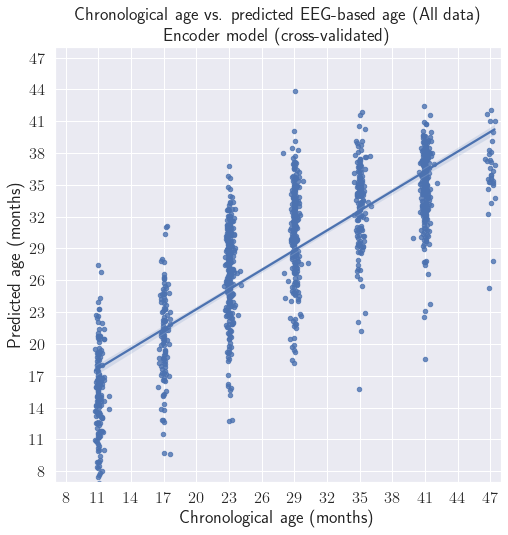

In [50]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/True_Pred/"

fig, ax = plt.subplots(figsize=(8,8))

x = model_performance_CV[model]['y_true'] # Test/Train
y = model_performance_CV[model]['y_pred'] # Test/Train

sns.regplot(x=x, y=y, scatter_kws={'s':20}) 

ax.set_xlim(7, 48)
ax.set_ylim(7, 48)

ax.set_xticks(np.arange(8, 48, 3.0))
ax.set_yticks(np.arange(8, 48, 3.0))

ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Chronological age (months)')
ax.set_ylabel('Predicted age (months)')
ax.set_title(f'Chronological age vs. predicted EEG-based age (All data) \n Encoder model (cross-validated)') # Test/Train

plt.grid()

fig_name = f"CV_{os.path.splitext(model)[0]}_true_pred.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

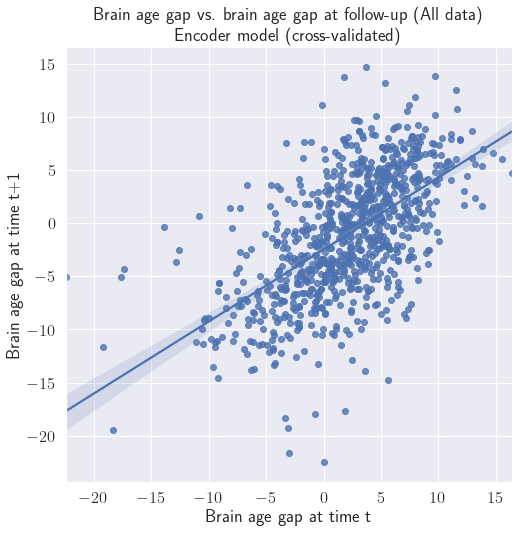

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/ErrorN_ErrorN1/"

fig, ax = plt.subplots(figsize=(8,8))

x = model_performance_CV[model]['errors_time_N'] # Test/Train
y = model_performance_CV[model]['errors_time_N1'] # Test/Train

#     sns.regplot(x=x, y=y, scatter_kws={'s':20}) 
sns.regplot(x=x, y=y) 

ax.grid()
ax.set_axisbelow(True)

ax.set_xlabel('Brain age gap at time t')
ax.set_ylabel('Brain age gap at time t+1')
ax.set_title(f'Brain age gap vs. brain age gap at follow-up (All data) \n Encoder model (cross-validated)') # Test/Train

plt.grid()

fig_name = f"CV_{os.path.splitext(model)[0]}_error_stability.pdf" # Test/Train
fig.savefig(os.path.join(save_path, fig_name), bbox_inches='tight')

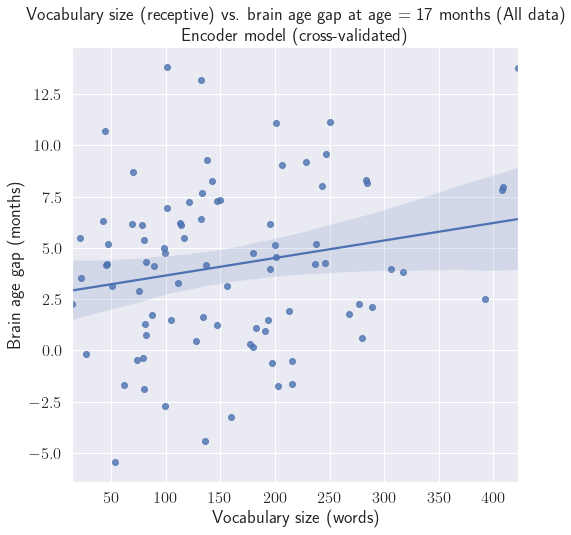

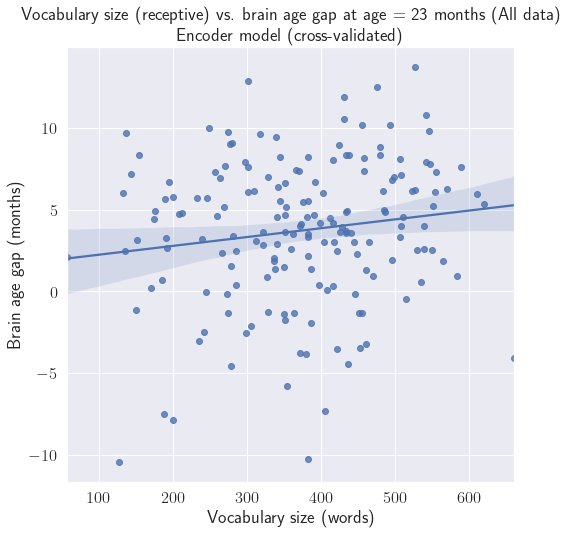

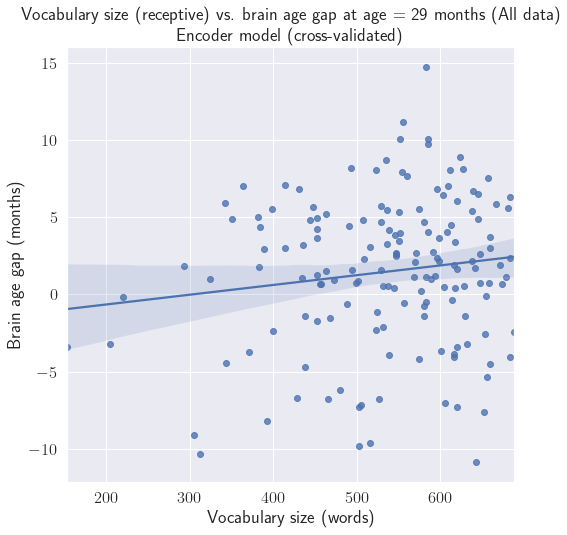

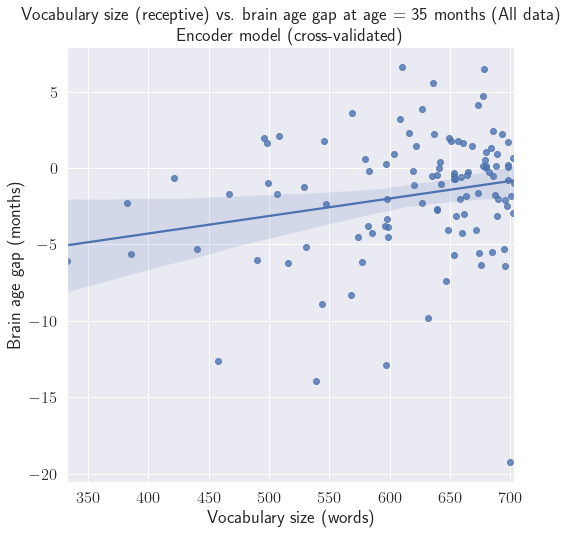

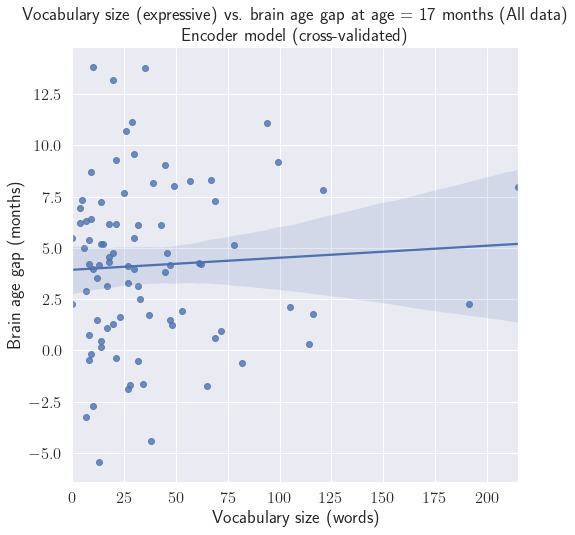

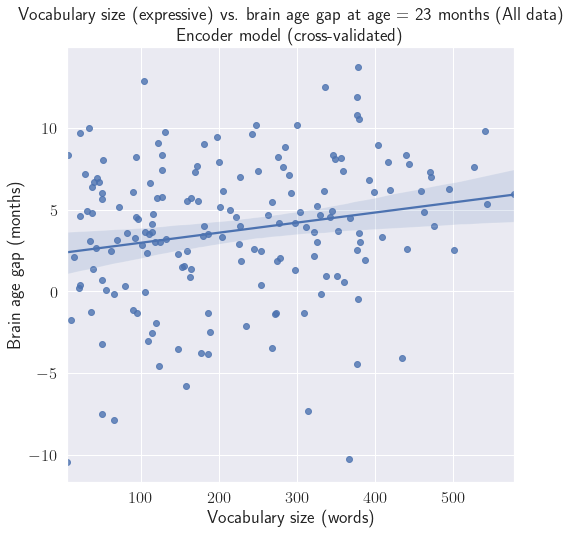

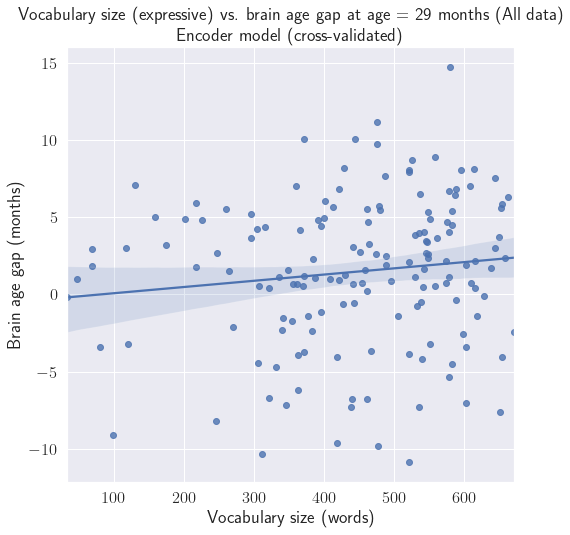

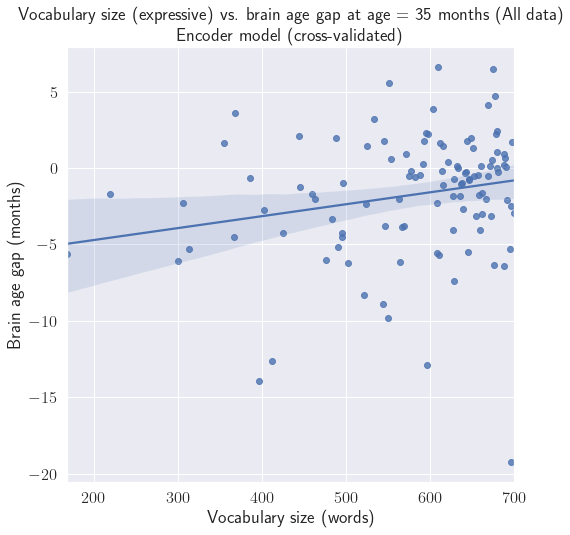

In [52]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(font_scale=1.5, rc={'text.usetex' : True})

save_path = "/Users/bbruns/Desktop/Visualisations/DeepLearning/"

categories = ["receptive", "productive"]
cat_names = ["receptive", "expressive"]

age_groups = [17, 23, 29, 35]
age_groups_path = ["Voc17/", "Voc23/", "Voc29/", "Voc35/"]

for j, category in enumerate(categories):
    for k, age_group in enumerate(age_groups):
        fig, ax = plt.subplots(figsize=(8,8))

        x = model_performance_CV[model][f'vocabulary_sizes_{age_group}_{category}'] # Test/Train
        y = model_performance_CV[model][f'brain_age_gaps_{age_group}_{category}'] # Test/Train

        sns.regplot(x=x, y=y) 

        ax.grid()
        ax.set_axisbelow(True)

        ax.set_xlabel('Vocabulary size (words)')
        ax.set_ylabel('Brain age gap (months)')
        ax.set_title(f'Vocabulary size ({cat_names[j]}) vs. brain age gap at age = {age_group} months (All data) \n Encoder model (cross-validated)') # Test/Train

        plt.grid()

        fig_name = f"CV_{os.path.splitext(model)[0]}_vocabulary_{cat_names[j]}_{age_group}.pdf" # Test/Train
        fig.savefig(os.path.join(save_path + age_groups_path[k], fig_name), bbox_inches='tight')